# Time Series Forecasting

This example shows using [Prophet](https://facebook.github.io/prophet/) and Dask for scalable time series forecasting.

> Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

As discussed in the [*Forecasting at scale*](https://peerj.com/preprints/3190/), large datasets aren't the only type of scaling challenge teams run into. In this example we'll focus on the third type of scaling challenege indentified in that paper:

> [I]n most realistic settings, a large number of forecasts will be created, necessitating efficient, automated means of evaluating and comparing them, as well as detecting when they are likely to be performing poorly. When hundreds or even thousands of forecasts are made, it becomes important to let machines do the hard work of model evaluation and comparison while efficiently using human feedback to fix performance problems.

That sounds like a perfect opportunity for Dask. We'll use Prophet and Dask together to parallize the *diagnostics* stage of research. It does not attempt to parallize the training of the model itself.

In [1]:
# This example currently relies on Prophet master
import subprocess

subprocess.call([
    "pip", "install", "Cython cmdstanpy==0.9.5 pystan numpy pandas matplotlib LunarCalendar convertdate holidays setuptools-git python-dateutil tqdm"
])

subprocess.call([
    "pip",
    "install",
    "git+https://github.com/facebook/prophet/#egg=fbprophet&subdirectory=python"
])

0

In [2]:
import pandas as pd
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


We'll walk through the example from the Prophet quickstart. These values represent the log daily page views for [Peyton Manning's wikipedia page](https://en.wikipedia.org/wiki/Peyton_Manning).

In [3]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv',
    parse_dates=['ds']
)
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


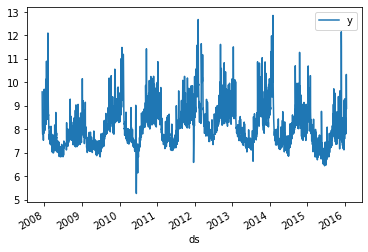

In [4]:
df.plot(x='ds', y='y');

Fitting the model takes a handful of seconds. Dask isn't involved at all here.

In [5]:
%%time
m = Prophet(daily_seasonality=False)
m.fit(df)

CPU times: user 2.24 s, sys: 59.8 ms, total: 2.3 s
Wall time: 2.3 s


And we can make a forecast. Again, Dask isn't involved here.

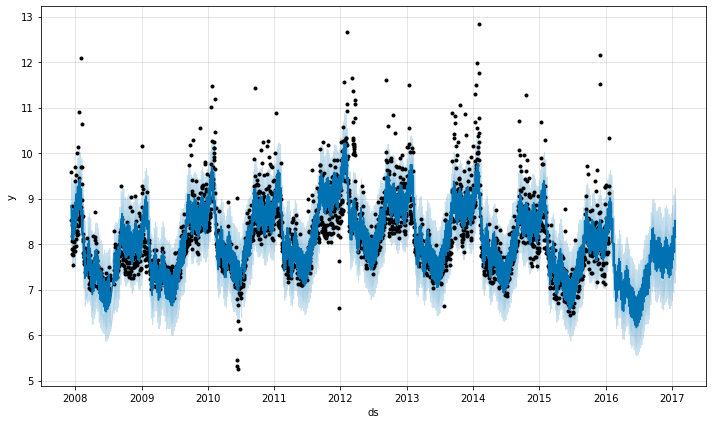

In [6]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
m.plot(forecast);

## Parallel Diagnostics

Prophet includes a `fbprophet.diagnostics.cross_validation` function method, which uses *simulated historical forecasts* to provide some idea of a model's quality.

> This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

See https://facebook.github.io/prophet/docs/diagnostics.html for more.

Internally, `cross_validation` generates a list of cutoff values to try. Prophet fits a model and computes some metrics for each of these. By default each model is fit sequentially, but the models can be trained in parallel using the `parallel=` keyword. On a single machine `parallel="processes"` is a good choice. For large problems where you'd like to distribute the work on a cluster, use `parallel="dask"` after you've connected to the cluster by creating a `Client`.

In [7]:
import dask
from distributed import Client, performance_report
import fbprophet.diagnostics

client = Client(threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:40067 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 8.36 GB


In [8]:
%%time
df_cv = fbprophet.diagnostics.cross_validation(
    m, initial="730 days", period="180 days", horizon="365 days",
    parallel="dask"
)

INFO:fbprophet:Making 11 forecasts with cutoffs between 2010-02-15 00:00:00 and 2015-01-20 00:00:00


INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:40067' processes=2 threads=2, memory=8.36 GB>


CPU times: user 1.99 s, sys: 346 ms, total: 2.34 s
Wall time: 50.8 s


Be sure to watch the Dask Dashboard as that runs. The models are fit in parallel on the cluster. At the start there's bit of overhead from having to move the model and data to the workers but after that the scaling looks quite nice.